In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
import math

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import SubAttr
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_train_transform, CUB_test_transform, TransformWrapper, x_transform
from lib.train import train
from lib.eval import show_explanation
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap, show_attribution, IntegratedGradients
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird, attribute2idx, dfs_freeze
from lib.utils import get_image_segmentation
from lib.data import MIMIC_ahrf, MIMIC_train_transform, MIMIC_test_transform, MIMIC

# CUB attribution

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


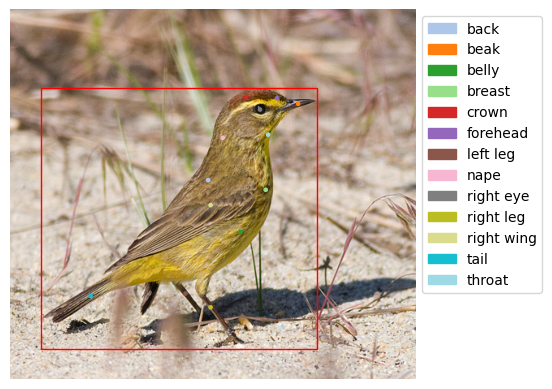

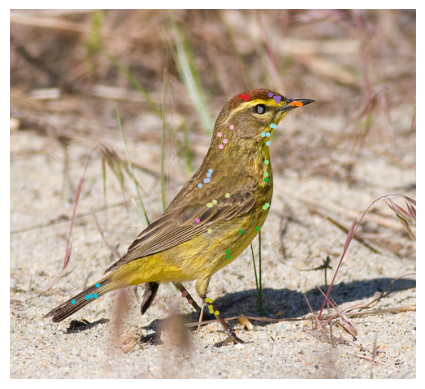

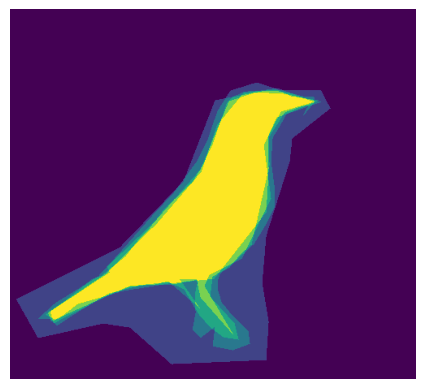

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


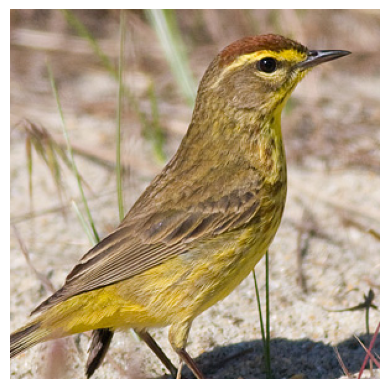

In [2]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

indices = [100, 10, 45]
# scale = 0.0
# cub_test = TransformWrapper(CUB_test_transform(Subset(cub, test_indices)), 
#                             x_transform(lambda x: x + scale * torch.randn_like(x)))

In [49]:
class GradCam():
    '''                                                                                                                                                                                       
    grad cam visualization                                                                                                                                                                    
    https://github.com/jacobgil/pytorch-grad-cam
    '''
    def __init__(self, model, use_cuda=True, **kwargs):
        from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
        from pytorch_grad_cam.utils.image import show_cam_on_image
        from lib.models import CCM, CCM_res
        if type(model[0]) == CCM:
            target_layers=[model[0].net_c[0].AuxLogits]#[0].Mixed_5b]
        # elif type(model[0]) == CCM_res:
        #     target_layers=[model[0].net1.net_c[0].Mixed_5b]
        self.cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

    def explain(self, input_image, target_class):
        from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
        targets = [ClassifierOutputTarget(target_class)]
        grayscale_cam = self.cam(input_tensor=input_image, targets=targets) # (n, 299, 299)
        sns.heatmap(gray_scale_cam[0])
        plt.show()
        grayscale_cam = torch.from_numpy(grayscale_cam.repeat(3, axis=0)).unsqueeze(1) # (n, 3, 299, 299)
        return grayscale_cam[0] # (3, 299, 299)
    
# net[0].net_c[0].Mixed_5b
# GradCam()
# visual_grounding(cub_test, model_names, nets, indices, verbose=False, has_segmentation=True, show_title=True,
#                  explain_method=lambda model: GradCam(model)) #, savename='attribution_cub')


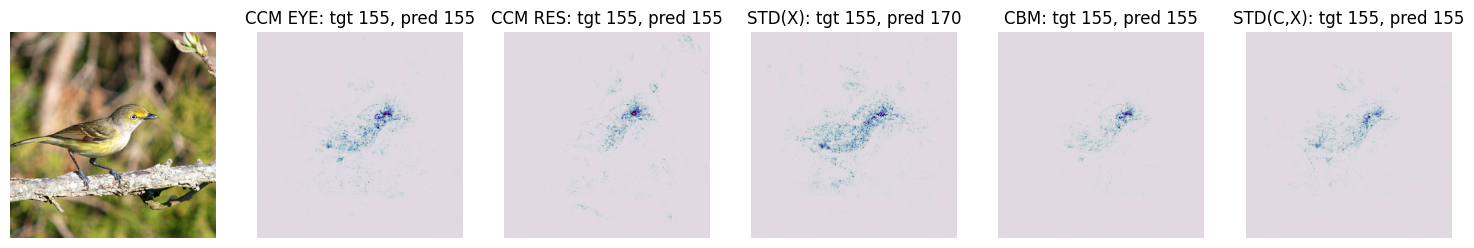

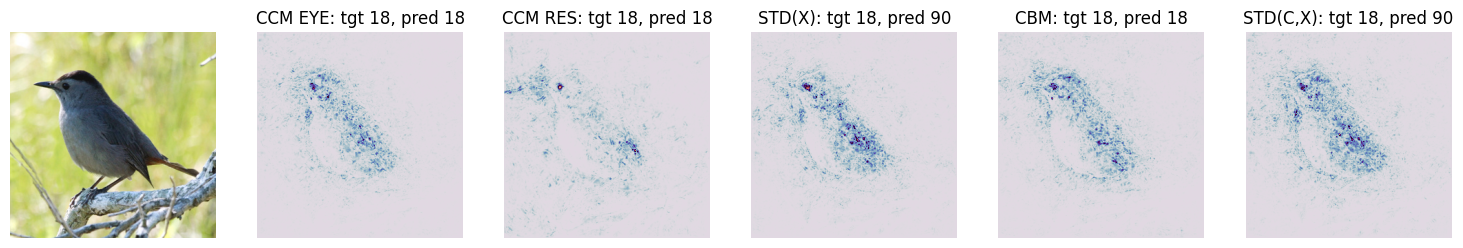

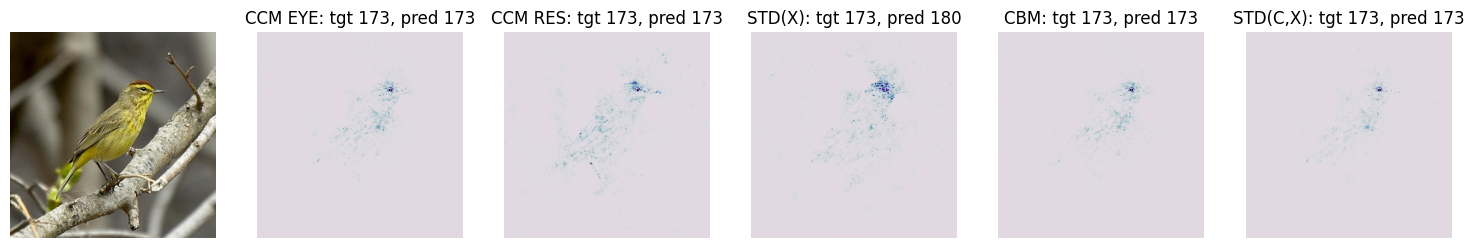

In [54]:
def visual_grounding(dataset, names, nets, indices, verbose=False, has_segmentation=False, show_title=True, savename=None,
                     explain_method=lambda model: IntegratedGradients(model, steps=10)):
    for idx in indices:
        outputs = show_explanation(dataset, idx, nets, 
                                   explain_method=explain_method,
                                   return_outputs=True, names=names, explain_target=False, show_title=show_title)
        if savename:
            plt.savefig(f'figures/{savename}_{idx}.png')
        plt.show()

        if not verbose: continue
        if has_segmentation:
            im = transforms.CenterCrop(299)(torch.from_numpy(np.array(Image.open(get_image_segmentation(dataset[idx]['filename'])))))
        for grad, name in zip(outputs, names):
            if has_segmentation:
                print(f'{name}   \t{grad.abs().sum(0)[im==0].abs().sum() / grad.abs().sum():.2%} attribution in bg')
            sns.heatmap(grad.sum(0), center=0, cmap='seismic') # (3, 299, 299)
            # sns.heatmap(grad.abs().sum(0), center=0, cmap='seismic', cbar=False) # (3, 299, 299)
            plt.axis('off')
            plt.show()
        
model_names = []
nets = []

net =  nn.Sequential(torch.load(f'../outputs/dnoise0/d749eff0ea5311ebb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
# exclusive for ccm models
net[0].c_no_grad = False
net[0].u_no_grad = False
model_names.append('CCM EYE')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/dnoise0/666adbb2f5bd11ebb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
model_names.append('CCM RES')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/e19c89eaea4911ebb773ac1f6b24a434/standard.pt'), nn.Softmax(1))
model_names.append('STD(X)')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/aca36656e58e11ebb773ac1f6b24a434/cbm.pt'), nn.Softmax(1))
# exclusive for cbm models
net[0].c_no_grad = False
model_names.append('CBM')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/dnoise0/36740f0aea7311ebb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
# exclusive for ccm models: std(c, x) is ccm with alpha=0
net[0].c_no_grad = False
net[0].u_no_grad = False
model_names.append('STD(C,X)')
nets.append(net)

indices = [100, 10, 45]
visual_grounding(cub_test, model_names, nets, indices, verbose=False, has_segmentation=True) # , show_title=False, savename='attribution_cub')
# visual_grounding(cub_test, model_names, nets, 
#                  list(np.random.randint(len(cub_test), size=(3,))), 
#                  verbose=True, has_segmentation=True)


# MIMIC attribution

317410 unknown Edema value in mimic data
# images: 107510
--------------- represented in dataset
image size: torch.Size([299, 299, 3])
has Edema: 1


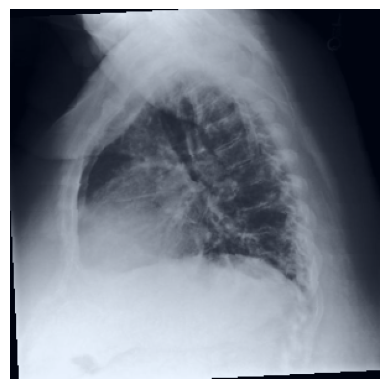

{'x': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x599>,
 'y': 1,
 'filename': '/data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/mimic-cxr-preprocessed/p10/p10000935/s50578979/d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738.jpg',
 'study_id': 50578979,
 'patient_id': 10000935,
 'gender': 'F',
 'task': 'Edema'}

In [52]:
mimic = MIMIC('Edema')

print('# images:', len(mimic))

indices = [99, 10, 45]
train_indices = list(range(100))
test_indices = list(range(100))
mimic_train = MIMIC_train_transform(Subset(mimic, train_indices))
mimic_test = MIMIC_test_transform(Subset(mimic, test_indices))

def show_data(d):
    '''d is dataset[idx]'''    
    filename = d['filename']

    print('--------------- represented in dataset')
    im, y = d['x'].permute(1,2,0), d['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print(f'has {d["task"]}: {y}')
    plt.axis('off')
    plt.show()
    
show_data(mimic_train[10])
mimic[0]

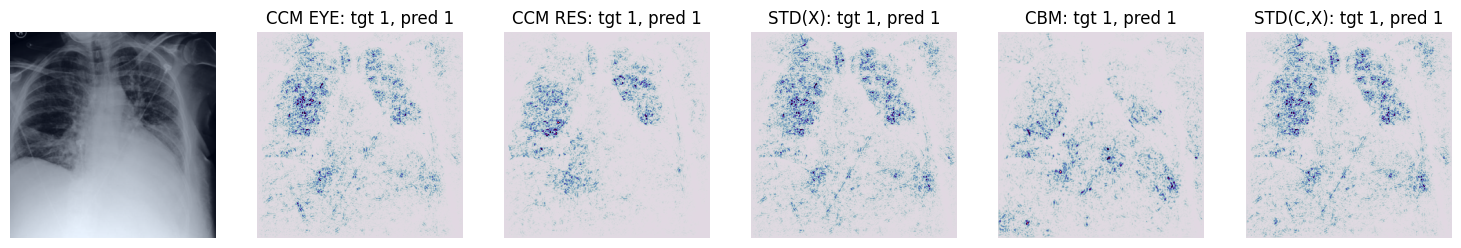

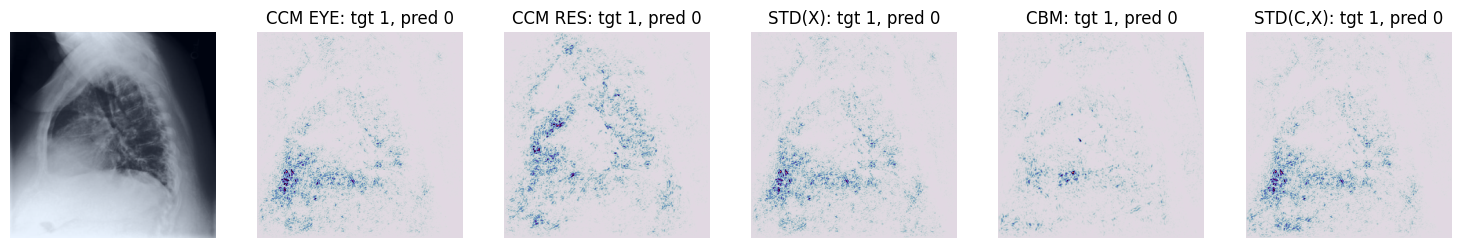

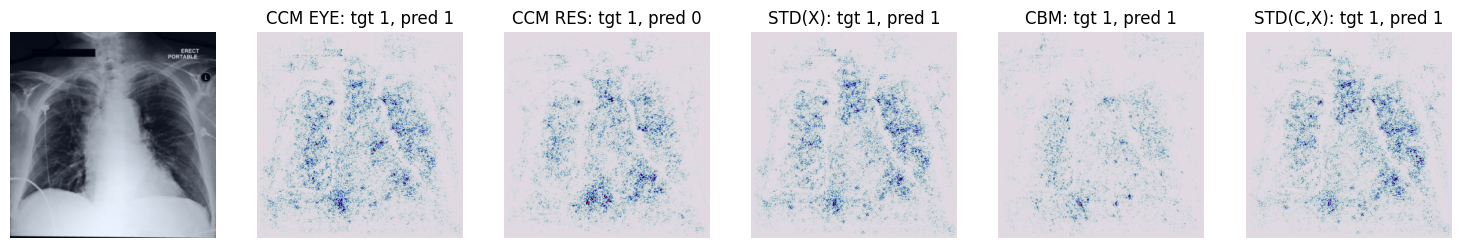

In [55]:
methods = ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)', 'finetune', 'ugrad']

def get_approach_name(fn, alpha):
    name = fn.split('/')[-1].split('_')[0]
    if name == 'ccm' and alpha == None:
        return methods[6]
    elif name == 'ccm' and alpha != 0:
        return methods[0]    
    elif name == 'ccmr':
        return methods[1]
    elif name == 'ccm' and alpha == 0:
        return methods[2]
    elif name == 'cbm':
        return methods[3]
    elif name == 'standard':
        return methods[4]
    elif name == 'finetune':
        return methods[5]    
    else:
        raise Exception(f"not defined name {name}")

## name, t, alpha from mimic_stats.ipynb for train corr 0.65 in Figure 3
# ('../outputs/84c54f5c766911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.8, None), # CCM RES
# ('../outputs/86698a8046bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0), # STD(C,X)
# ('../outputs/404868d246bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0.01), # CCM EYE
# ('../outputs/f77275b2425611ecb773ac1f6b24a434/standard_Edema.npz', 0.8, None), # STD(X)
# ('../outputs/80b3060c420211ecb773ac1f6b24a434/cbm_Edema.npz', 0.8, None), # CBM

model_names = []
nets = []

net =  nn.Sequential(torch.load(f'../outputs/404868d246bc11ecb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
# exclusive for ccm models
net[0].c_no_grad = False
net[0].u_no_grad = False
model_names.append('CCM EYE')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/84c54f5c766911ec830e8fa97a4e8129/ccmr.pt'), nn.Softmax(1))
model_names.append('CCM RES')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/f77275b2425611ecb773ac1f6b24a434/standard.pt'), nn.Softmax(1))
model_names.append('STD(X)')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/80b3060c420211ecb773ac1f6b24a434/cbm.pt'), nn.Softmax(1))
# exclusive for cbm models
net[0].c_no_grad = False
model_names.append('CBM')
nets.append(net)

net =  nn.Sequential(torch.load(f'../outputs/86698a8046bc11ecb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
# exclusive for ccm models: std(c, x) is ccm with alpha=0
net[0].c_no_grad = False
net[0].u_no_grad = False
model_names.append('STD(C,X)')
nets.append(net)

# visual_grounding(cub_test, model_names, nets, indices, verbose=False, has_segmentation=False) # ridiculous
indices = [99, 10, 45]
visual_grounding(mimic_test, model_names, nets, indices, verbose=False, has_segmentation=False) #, show_title=False, savename='attribution_mimic')
# visual_grounding(mimic_test, model_names, nets, 
#                  list(np.random.randint(len(mimic_test), size=(3,))), 
#                  verbose=True, has_segmentation=False)

# segmentation of birds

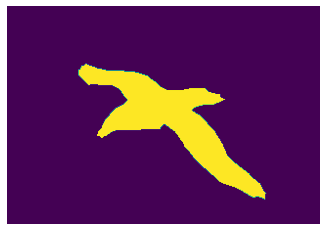

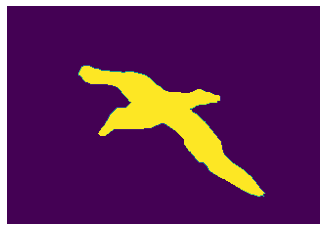

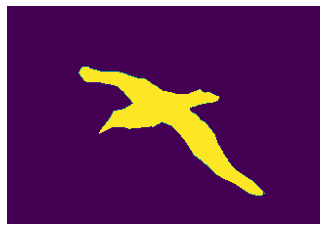

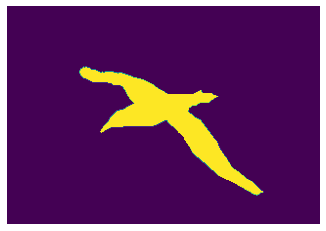

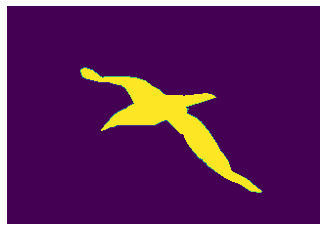

[0.  0.2 0.4 0.6 0.8 1. ]


In [16]:
# rough annotation https://vision.cornell.edu/se3/wp-content/uploads/2014/09/WelinderEtal10_CUB-200.pdf
image = plt.imread('../datasets/bird_data/segmentations/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.png')
plt.imshow(image>0)
plt.axis('off')
plt.show()

plt.imshow(image>0.2)
plt.axis('off')
plt.show()

plt.imshow(image>0.4)
plt.axis('off')
plt.show()

plt.imshow(image>0.6)
plt.axis('off')
plt.show()

plt.imshow(image>0.8)
plt.axis('off')
plt.show()

print(np.unique(image))

# masking the input

class id: 155
l2^2(grad): 0.000939160818234086


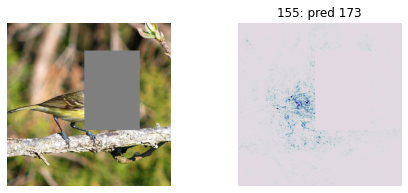

class id: 18
l2^2(grad): 0.10502680391073227


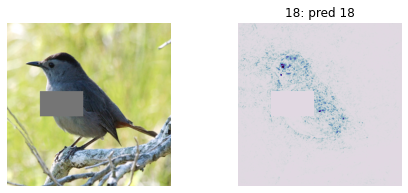

class id: 173
l2^2(grad): 8.643487672088668e-05


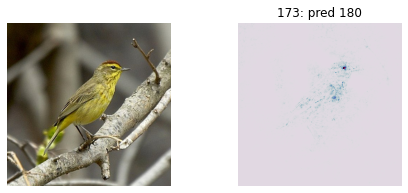

In [6]:
cub_test = TransformWrapper(CUB_test_transform(Subset(cub, test_indices)), 
                            x_transform(transforms.RandomErasing()))
net = nn.Sequential(torch.load(f'../outputs/9d6b1fe6330211ecb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
for idx in [100, 10, 45]:
    show_explanation(cub_test, idx, [net], 
                     explain_method=lambda model: IntegratedGradients(model, steps=10))